In [39]:
# from vae_scott import ResidualBlock, ResNetVAEEncoder, ResNetVAEDecoder, ResNetVAEEncoderSpatial, ResNetVAEDecoderSpatial, ResNetVAE
from vae_scott import ResNetVAE, test_inference, test_inference_spatial, log_example_images
import wandb

import torch
from torch import nn, optim, utils
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, RandomAffine, RandomErasing
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [41]:
spatial_vae = ResNetVAE().to(device)

In [4]:
vae_7 = ResNetVAE(latent_dim=7, spatial=False).to(device)

In [42]:
wandb.login()
wandb.finish() # just in case we're aborting runs & restarting

In [50]:
# optional: define additional data augmentation transformers for the dataloader
train_transforms = torchvision.transforms.Compose([
    ToTensor(),
    # uncomment next lines for extra augmentations
    #RandomAffine(degrees=15, translate=(0.1, 0.1)),
    #RandomErasing(p=0.2, scale=(0.02, 0.1))
])

train_ds = MNIST(root='./data', train=True,  download=True, transform=train_transforms)
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
val_ds = test_ds  #alias val for test
print(f"Data set lengths: train: {len(train_ds)}, test: {len(test_ds)}")



batch_size = 128   # could make this bigger; note for MNIST on Colab we're disk-speed limited, not GPU-limited
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=2, shuffle=True, persistent_workers=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=2, shuffle=False, persistent_workers=True)
val_dl = test_dl # alias val <--> test

Data set lengths: train: 60000, test: 10000


In [52]:
project = "spatial_vae_conv_testing"
recon_criterion = F.binary_cross_entropy_with_logits

def vae_loss(x, x_logits, mu, log_var, beta: float):
    recon_loss = recon_criterion(x_logits, x)
    kl_per_elem = -0.5 * (1 + log_var - mu.pow(2) - log_var.exp())
    kl = kl_per_elem.view(kl_per_elem.size(0), -1).sum(dim=1).mean()
    loss = recon_loss + beta * kl
    return loss, recon_loss, kl

def train_model_vae(
    model, train_loader, val_loader, name=None,
    epochs=20, lr=2e-3, weight_decay=5e-5,
    beta_final=1.0, warmup_epochs=10, grad_clip=5.0, ema=0.97
):
    device = next(model.parameters()).device

    # ---- W&B ----
    wandb.finish()
    wandb.init(project=project, name=name, reinit='finish_previous')
    wandb.config.update({
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": lr,
        "model": model.__class__.__name__,
        "optimizer": "Adam",
        "device": str(device),
    })

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    global_step = 0
    train_loss_avg = None

    for epoch in range(epochs):
        model.train()

        beta = beta_final * min((epoch + 1) / warmup_epochs, 1.0)

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            optimizer.zero_grad()

            z, x_hat, mu, log_var, z_hat = model(data)

            recon_loss = recon_criterion(x_hat, data)
            kl = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
            loss = recon_loss + beta * kl

            # loss, recon_loss, kl = vae_loss(data, x_hat, mu, log_var, beta)

            loss.backward()
            # if grad_clip is not None:
            #     clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            train_loss_avg = loss.item() if train_loss_avg is None else ema * train_loss_avg + (1 - ema) * loss.item()

            wandb.log({
                "step": global_step,
                "train_loss_ema": train_loss_avg,
                "train_loss": loss.item(),
                "recon_loss": recon_loss.item(),
                "kl_loss": kl.item(),
                "beta": beta,
                "beta*kl": (beta * kl).item(),
            })
            global_step += 1
            pbar.set_postfix(Loss=f"{train_loss_avg:.4f}", Recon=f"{recon_loss.item():.4f}", KLw=f"{(beta*kl).item():.5f}")

        # ---- validation ----
        model.eval()
        val_loss = val_recon = val_kl = 0.0
        mu_stats = []

        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                z, x_hat, mu, log_var, z_hat = model(data)

                recon = recon_criterion(x_hat, data)
                kl = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
                loss = recon + beta * kl

                val_loss += loss.item(); val_recon += recon.item(); val_kl += kl.item()
                mu_stats.append(mu)

        n = len(val_loader)
        val_loss /= n; val_recon /= n; val_kl /= n

        mu_all = torch.cat(mu_stats, dim=0)
        mu_mean = mu_all.mean().item(); mu_std = mu_all.std().item()

        wandb.log({
            "epoch": epoch + 1,
            "val_loss": val_loss,
            "val_recon_loss": val_recon,
            "val_kl_loss": val_kl,
            "mu_mean": mu_mean,
            "mu_std": mu_std,
        })
        print(f"Epoch {epoch+1:02d} | beta {beta:.3f} | "
                f"val {val_loss:.4f} | recon {val_recon:.4f} | KL {val_kl:.4f} | "
                f"μ_mean {mu_mean:.3f} μ_std {mu_std:.3f}")

        # visualize with sigmoid at eval-time only
        log_example_images(model, val_loader.dataset, epoch + 1, spatial=True, n=5)

    wandb.finish()
    return val_loss

In [53]:
train_model_vae(spatial_vae, train_dl, val_dl, name="test_vae_ld7_v1", beta_final=0.005, epochs=20)

beta,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▅▅▆▆▆▆▆▇▇▇████████████████
beta*kl,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇██
kl_loss,█▅▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mu_mean,█▆▃▄▅▅▄▁▂▃▅▆
mu_std,█▅▃▃▂▁▁▁▁▂▅▂
recon_loss,▄▂▆▃▄▅▂▃▆▅▃▄▅▂▅▄▅▆▆▆▃▅▇▂▂▄▆▅▆▃▃▆▅▁▄▂▄█▄▆
step,▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
train_loss,█▃▃▂▁▃▂▂▂▂▂▃▃▁▂▃▂▁▂▃▂▃▂▂▁▂▃▃▁▂▃▁▁▃▂▃▁▂▃▂
train_loss_ema,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+3,...


Epoch 1/20: 100%|██████████| 469/469 [00:36<00:00, 12.94it/s, KLw=0.00159, Loss=0.0785, Recon=0.0753]


Epoch 01 | beta 0.001 | val 0.0753 | recon 0.0736 | KL 3.2636 | μ_mean 0.006 μ_std 1.363


Epoch 2/20: 100%|██████████| 469/469 [00:32<00:00, 14.43it/s, KLw=0.00286, Loss=0.0764, Recon=0.0789]


Epoch 02 | beta 0.001 | val 0.0735 | recon 0.0707 | KL 2.7870 | μ_mean -0.056 μ_std 1.087


Epoch 3/20: 100%|██████████| 469/469 [00:32<00:00, 14.45it/s, KLw=0.00393, Loss=0.0760, Recon=0.0732]


Epoch 03 | beta 0.002 | val 0.0731 | recon 0.0693 | KL 2.5687 | μ_mean 0.097 μ_std 1.107


Epoch 4/20: 100%|██████████| 469/469 [00:32<00:00, 14.52it/s, KLw=0.00489, Loss=0.0758, Recon=0.0711]


Epoch 04 | beta 0.002 | val 0.0749 | recon 0.0701 | KL 2.4162 | μ_mean -0.059 μ_std 0.969


Epoch 5/20: 100%|██████████| 469/469 [00:32<00:00, 14.46it/s, KLw=0.00589, Loss=0.0771, Recon=0.0708]


Epoch 05 | beta 0.003 | val 0.0753 | recon 0.0695 | KL 2.3013 | μ_mean 0.111 μ_std 1.102


Epoch 6/20: 100%|██████████| 469/469 [00:37<00:00, 12.51it/s, KLw=0.00680, Loss=0.0771, Recon=0.0730]


Epoch 06 | beta 0.003 | val 0.0777 | recon 0.0709 | KL 2.2712 | μ_mean -0.043 μ_std 0.967


Epoch 7/20: 100%|██████████| 469/469 [00:38<00:00, 12.13it/s, KLw=0.00785, Loss=0.0787, Recon=0.0719]


Epoch 07 | beta 0.003 | val 0.0770 | recon 0.0693 | KL 2.1931 | μ_mean -0.032 μ_std 0.990


Epoch 8/20: 100%|██████████| 469/469 [00:38<00:00, 12.15it/s, KLw=0.00853, Loss=0.0799, Recon=0.0744]


Epoch 08 | beta 0.004 | val 0.0781 | recon 0.0697 | KL 2.1157 | μ_mean -0.091 μ_std 0.936


Epoch 9/20: 100%|██████████| 469/469 [00:36<00:00, 12.74it/s, KLw=0.00912, Loss=0.0811, Recon=0.0757]


Epoch 09 | beta 0.005 | val 0.0798 | recon 0.0705 | KL 2.0852 | μ_mean -0.049 μ_std 0.971


Epoch 10/20: 100%|██████████| 469/469 [00:36<00:00, 12.83it/s, KLw=0.00972, Loss=0.0813, Recon=0.0702]


Epoch 10 | beta 0.005 | val 0.0792 | recon 0.0697 | KL 1.9058 | μ_mean 0.013 μ_std 0.966


Epoch 11/20: 100%|██████████| 469/469 [00:34<00:00, 13.44it/s, KLw=0.00973, Loss=0.0817, Recon=0.0711]


Epoch 11 | beta 0.005 | val 0.0792 | recon 0.0696 | KL 1.9180 | μ_mean -0.093 μ_std 0.880


Epoch 12/20: 100%|██████████| 469/469 [00:34<00:00, 13.55it/s, KLw=0.00967, Loss=0.0809, Recon=0.0704]


Epoch 12 | beta 0.005 | val 0.0791 | recon 0.0694 | KL 1.9388 | μ_mean -0.003 μ_std 0.959


Epoch 13/20: 100%|██████████| 469/469 [00:34<00:00, 13.75it/s, KLw=0.00956, Loss=0.0810, Recon=0.0690]


Epoch 13 | beta 0.005 | val 0.0797 | recon 0.0701 | KL 1.9254 | μ_mean -0.091 μ_std 0.934


Epoch 14/20: 100%|██████████| 469/469 [00:35<00:00, 13.26it/s, KLw=0.00944, Loss=0.0806, Recon=0.0739]


Epoch 14 | beta 0.005 | val 0.0784 | recon 0.0693 | KL 1.8183 | μ_mean 0.033 μ_std 0.960


Epoch 15/20: 100%|██████████| 469/469 [00:34<00:00, 13.79it/s, KLw=0.00959, Loss=0.0810, Recon=0.0697]


Epoch 15 | beta 0.005 | val 0.0786 | recon 0.0691 | KL 1.9065 | μ_mean 0.095 μ_std 0.999


Epoch 16/20: 100%|██████████| 469/469 [00:34<00:00, 13.45it/s, KLw=0.00960, Loss=0.0811, Recon=0.0733]


Epoch 16 | beta 0.005 | val 0.0785 | recon 0.0691 | KL 1.8777 | μ_mean -0.030 μ_std 0.945


Epoch 17/20: 100%|██████████| 469/469 [00:33<00:00, 13.82it/s, KLw=0.00965, Loss=0.0811, Recon=0.0758]


Epoch 17 | beta 0.005 | val 0.0802 | recon 0.0706 | KL 1.9291 | μ_mean 0.051 μ_std 0.998


Epoch 18/20: 100%|██████████| 469/469 [00:34<00:00, 13.44it/s, KLw=0.00950, Loss=0.0805, Recon=0.0694]


Epoch 18 | beta 0.005 | val 0.0784 | recon 0.0689 | KL 1.8963 | μ_mean 0.150 μ_std 1.036


Epoch 19/20: 100%|██████████| 469/469 [00:34<00:00, 13.53it/s, KLw=0.00937, Loss=0.0812, Recon=0.0691]


Epoch 19 | beta 0.005 | val 0.0799 | recon 0.0702 | KL 1.9446 | μ_mean -0.019 μ_std 0.924


Epoch 20/20: 100%|██████████| 469/469 [00:37<00:00, 12.62it/s, KLw=0.00940, Loss=0.0804, Recon=0.0739]


Epoch 20 | beta 0.005 | val 0.0801 | recon 0.0710 | KL 1.8102 | μ_mean 0.089 μ_std 0.982


beta,▁▁▁▁▂▂▃▃▃▃▄▅▅▅▆▆▆▇██████████████████████
beta*kl,▁▂▂▃▃▃▃▄▄▄▅▅▆▆▆▇▇▇██████████████▇███▇█▇▇
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
kl_loss,▁█▇▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▃▃▂▃▂▃
mu_mean,▄▂▆▂▇▂▃▁▂▄▁▄▁▅▆▃▅█▃▆
mu_std,█▄▄▂▄▂▃▂▂▂▁▂▂▂▃▂▃▃▂▂
recon_loss,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇███
train_loss,█▄▃▂▂▂▂▃▃▂▂▄▁▃▄▄▃▄▅▄▄▄▄▅▃▃▄▃▃▅▄▄▄▄▂▄▃▄▄▃
train_loss_ema,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+3,...


0.08010079485328891

In [7]:
train_model_vae(spatial_vae, train_dl, val_dl, name="vae_ld7", epochs=15)

Epoch 1/15: 100%|██████████| 469/469 [00:37<00:00, 12.40it/s, Loss=0.1309, Recon=0.1292, KL*w=0.000000]  


Epoch 1: Val_Loss 0.1224 | Recon_Loss 0.1224 | kl_Loss 28.1414


Epoch 2/15: 100%|██████████| 469/469 [01:14<00:00,  6.33it/s, Loss=0.1137, Recon=0.1139, KL*w=0.000426]


Epoch 2: Val_Loss 0.1072 | Recon_Loss 0.1069 | kl_Loss 30.4952


Epoch 3/15: 100%|██████████| 469/469 [00:33<00:00, 14.19it/s, Loss=0.1056, Recon=0.1019, KL*w=0.000672]


Epoch 3: Val_Loss 0.1071 | Recon_Loss 0.1066 | kl_Loss 25.5284


Epoch 4/15: 100%|██████████| 469/469 [00:33<00:00, 14.02it/s, Loss=0.0998, Recon=0.1025, KL*w=0.000724]


Epoch 4: Val_Loss 0.1043 | Recon_Loss 0.1037 | kl_Loss 20.0791


Epoch 5/15: 100%|██████████| 469/469 [00:33<00:00, 14.15it/s, Loss=0.0950, Recon=0.0918, KL*w=0.000771]


Epoch 5: Val_Loss 0.1052 | Recon_Loss 0.1045 | kl_Loss 16.3287


Epoch 6/15: 100%|██████████| 469/469 [00:35<00:00, 13.24it/s, Loss=0.0920, Recon=0.0883, KL*w=0.000742]


Epoch 6: Val_Loss 0.0979 | Recon_Loss 0.0972 | kl_Loss 13.2757


Epoch 7/15: 100%|██████████| 469/469 [00:43<00:00, 10.84it/s, Loss=0.0896, Recon=0.0889, KL*w=0.000731]


Epoch 7: Val_Loss 0.0935 | Recon_Loss 0.0928 | kl_Loss 11.0033


Epoch 8/15: 100%|██████████| 469/469 [00:40<00:00, 11.50it/s, Loss=0.0872, Recon=0.0861, KL*w=0.000713]


Epoch 8: Val_Loss 0.0908 | Recon_Loss 0.0902 | kl_Loss 9.4906


Epoch 9/15: 100%|██████████| 469/469 [00:36<00:00, 12.92it/s, Loss=0.0853, Recon=0.0845, KL*w=0.000717]


Epoch 9: Val_Loss 0.0880 | Recon_Loss 0.0873 | kl_Loss 8.3698


Epoch 10/15: 100%|██████████| 469/469 [00:34<00:00, 13.60it/s, Loss=0.0840, Recon=0.0814, KL*w=0.000702]


Epoch 10: Val_Loss 0.0814 | Recon_Loss 0.0807 | kl_Loss 7.4903


Epoch 11/15: 100%|██████████| 469/469 [00:35<00:00, 13.35it/s, Loss=0.0829, Recon=0.0810, KL*w=0.000724]


Epoch 11: Val_Loss 0.0889 | Recon_Loss 0.0882 | kl_Loss 6.8302


Epoch 12/15: 100%|██████████| 469/469 [00:33<00:00, 13.98it/s, Loss=0.0816, Recon=0.0812, KL*w=0.000685]


Epoch 12: Val_Loss 0.0809 | Recon_Loss 0.0803 | kl_Loss 6.5026


Epoch 13/15: 100%|██████████| 469/469 [00:33<00:00, 13.92it/s, Loss=0.0806, Recon=0.0788, KL*w=0.000659]


Epoch 13: Val_Loss 0.0787 | Recon_Loss 0.0781 | kl_Loss 6.2990


Epoch 14/15: 100%|██████████| 469/469 [00:33<00:00, 13.88it/s, Loss=0.0794, Recon=0.0808, KL*w=0.000624]


Epoch 14: Val_Loss 0.0765 | Recon_Loss 0.0759 | kl_Loss 6.0408


Epoch 15/15: 100%|██████████| 469/469 [00:33<00:00, 13.89it/s, Loss=0.0788, Recon=0.0777, KL*w=0.000612]


Epoch 15: Val_Loss 0.0779 | Recon_Loss 0.0773 | kl_Loss 5.9806


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
kl_loss,▅▇█████▇▇▇▆▅▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
kl_weight,▁▁▁▂▂▂▂▃▃▃▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████
recon_loss,█▇▅▅▅▅▅▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_kl_loss,▇█▇▅▄▃▂▂▂▁▁▁▁▁▁
val_loss,█▆▆▅▅▄▄▃▃▂▃▂▁▁▁
val_recon_loss,█▆▆▅▅▄▄▃▃▂▃▂▁▁▁
weighted_kl_loss,▁▁▁▁▁▁▁▄▇▇█▇▇▇█▇▇▇▇▇▇█▇▇▇▇▆▇▇▇▆▆▆▆▆▆▆▆▆▆
epoch,15


0.07792766561991052

In [54]:
from helpers import plot_latent_space

In [72]:
plot_latent_space(spatial_vae, test_dl, use_3d=True, reducer='tsne')

In [71]:
from safetensors.torch import save_file

save_file(spatial_vae.state_dict(), 'models/safetensors/vae/initial20epoch_vae.safetensors')

In [47]:
vae = ResNetVAE(latent_dim=7, spatial=True).to(device)
vae.load_state_dict(torch.load(f'models/spatial_ae_{7}.pth', map_location=device))
vae.eval()

ResNetVAE(
  (encoder): ResNetVAEEncoderSpatial(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (levels): ModuleList(
      (0): ModuleList(
        (0-3): 4 x ResidualBlock(
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ModuleList(
        (0-3): 4 x ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 

In [51]:
plot_latent_space(vae, train_dl, use_3d=True, reducer='tsne')

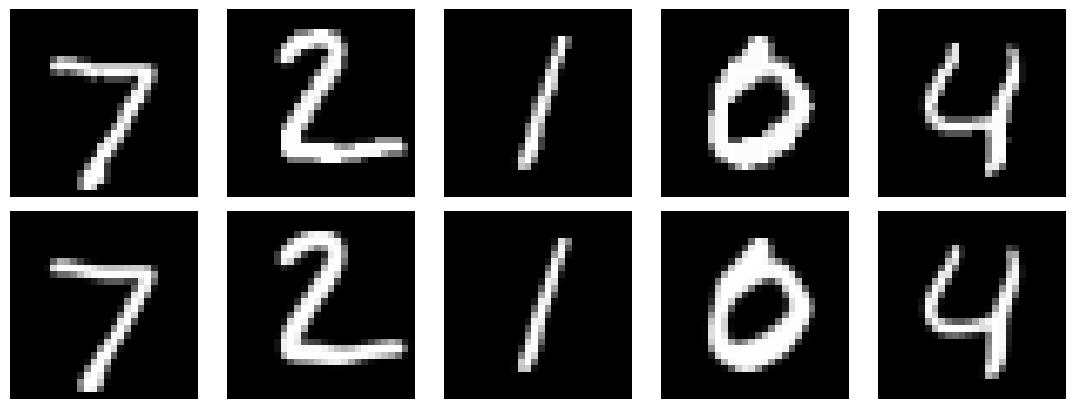

In [48]:
test_inference(vae, test_ds, [0,1,2,3,4])

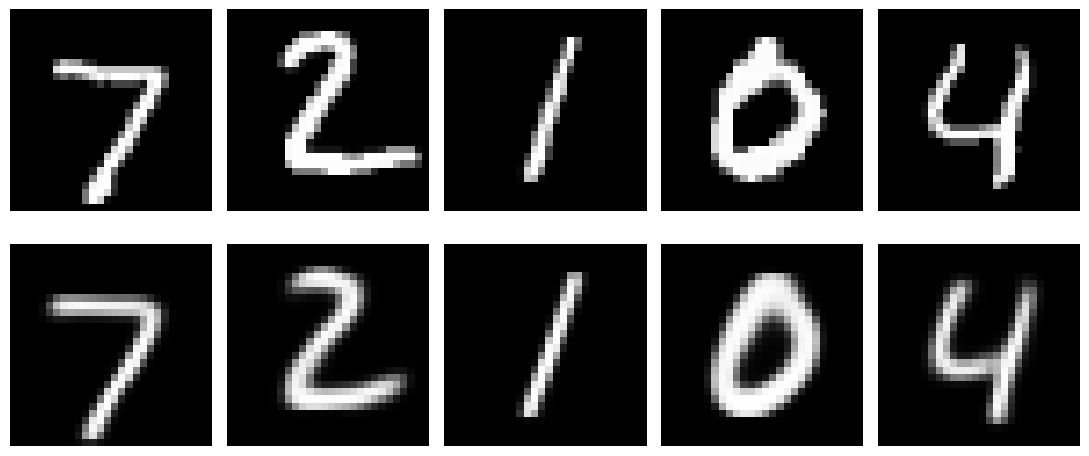

In [46]:
test_inference_spatial(vae_7, test_ds, range(5))

In [47]:
torch.save(vae_7.state_dict(), "models/vae_7.pth")

In [30]:
spatial_49 = ResNetVAE(latent_dim=49)

In [31]:
train_model_vae(spatial_49, train_dl, val_dl, name="spatial_l_49",loss_func='bce_with_logits', epochs=20)

Epoch 1/20: 100%|██████████| 469/469 [00:32<00:00, 14.63it/s, Loss=0.0746, Recon=0.0790, KL*w=0.000000]


Epoch 1: Val_Loss 0.0720 | Recon_Loss 0.0720 | kl_Loss 83.8868


Epoch 2/20: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s, Loss=0.0722, Recon=0.0752, KL*w=0.000253]


Epoch 2: Val_Loss 0.0712 | Recon_Loss 0.0710 | kl_Loss 24.6912


Epoch 3/20: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s, Loss=0.0712, Recon=0.0697, KL*w=0.000287]


Epoch 3: Val_Loss 0.0698 | Recon_Loss 0.0695 | kl_Loss 14.2651


Epoch 4/20: 100%|██████████| 469/469 [00:32<00:00, 14.56it/s, Loss=0.0705, Recon=0.0720, KL*w=0.000304]


Epoch 4: Val_Loss 0.0684 | Recon_Loss 0.0681 | kl_Loss 10.1817


Epoch 5/20: 100%|██████████| 469/469 [00:32<00:00, 14.24it/s, Loss=0.0702, Recon=0.0680, KL*w=0.000325]


Epoch 5: Val_Loss 0.0689 | Recon_Loss 0.0686 | kl_Loss 8.1732


Epoch 6/20: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s, Loss=0.0696, Recon=0.0700, KL*w=0.000354]


Epoch 6: Val_Loss 0.0685 | Recon_Loss 0.0681 | kl_Loss 7.2257


Epoch 7/20: 100%|██████████| 469/469 [00:38<00:00, 12.22it/s, Loss=0.0701, Recon=0.0708, KL*w=0.000387]


Epoch 7: Val_Loss 0.0689 | Recon_Loss 0.0685 | kl_Loss 6.5761


Epoch 8/20: 100%|██████████| 469/469 [00:37<00:00, 12.45it/s, Loss=0.0696, Recon=0.0679, KL*w=0.000377]


Epoch 8: Val_Loss 0.0695 | Recon_Loss 0.0691 | kl_Loss 5.7444


Epoch 9/20: 100%|██████████| 469/469 [00:37<00:00, 12.64it/s, Loss=0.0693, Recon=0.0689, KL*w=0.000433]


Epoch 9: Val_Loss 0.0668 | Recon_Loss 0.0664 | kl_Loss 5.7425


Epoch 10/20: 100%|██████████| 469/469 [00:33<00:00, 13.80it/s, Loss=0.0690, Recon=0.0671, KL*w=0.000464]


Epoch 10: Val_Loss 0.0676 | Recon_Loss 0.0672 | kl_Loss 5.3850


Epoch 11/20: 100%|██████████| 469/469 [00:33<00:00, 14.14it/s, Loss=0.0692, Recon=0.0688, KL*w=0.000476]


Epoch 11: Val_Loss 0.0675 | Recon_Loss 0.0670 | kl_Loss 4.7649


Epoch 12/20: 100%|██████████| 469/469 [00:33<00:00, 14.02it/s, Loss=0.0689, Recon=0.0708, KL*w=0.000503]


Epoch 12: Val_Loss 0.0666 | Recon_Loss 0.0661 | kl_Loss 4.8154


Epoch 13/20: 100%|██████████| 469/469 [00:41<00:00, 11.33it/s, Loss=0.0682, Recon=0.0686, KL*w=0.000469]


Epoch 13: Val_Loss 0.0668 | Recon_Loss 0.0663 | kl_Loss 4.6779


Epoch 14/20: 100%|██████████| 469/469 [00:35<00:00, 13.39it/s, Loss=0.0686, Recon=0.0695, KL*w=0.000470]


Epoch 14: Val_Loss 0.0666 | Recon_Loss 0.0661 | kl_Loss 4.7066


Epoch 15/20: 100%|██████████| 469/469 [00:32<00:00, 14.22it/s, Loss=0.0685, Recon=0.0697, KL*w=0.000475]


Epoch 15: Val_Loss 0.0669 | Recon_Loss 0.0664 | kl_Loss 4.6970


Epoch 16/20: 100%|██████████| 469/469 [00:33<00:00, 14.08it/s, Loss=0.0680, Recon=0.0657, KL*w=0.000459]


Epoch 16: Val_Loss 0.0665 | Recon_Loss 0.0661 | kl_Loss 4.6106


Epoch 17/20: 100%|██████████| 469/469 [00:33<00:00, 13.87it/s, Loss=0.0685, Recon=0.0658, KL*w=0.000459]


Epoch 17: Val_Loss 0.0661 | Recon_Loss 0.0657 | kl_Loss 4.6227


Epoch 18/20: 100%|██████████| 469/469 [00:32<00:00, 14.25it/s, Loss=0.0685, Recon=0.0653, KL*w=0.000451]


Epoch 18: Val_Loss 0.0660 | Recon_Loss 0.0656 | kl_Loss 4.4788


Epoch 19/20: 100%|██████████| 469/469 [00:34<00:00, 13.50it/s, Loss=0.0684, Recon=0.0650, KL*w=0.000440]


Epoch 19: Val_Loss 0.0678 | Recon_Loss 0.0674 | kl_Loss 4.6379


Epoch 20/20: 100%|██████████| 469/469 [00:34<00:00, 13.41it/s, Loss=0.0681, Recon=0.0690, KL*w=0.000462]


Epoch 20: Val_Loss 0.0660 | Recon_Loss 0.0655 | kl_Loss 4.5222


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
kl_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_weight,▁▁▁▂▂▂▂▃▃▃▅▅▅▅▆▇████████████████████████
recon_loss,▆▅█▄▄▃▃▃▄▅▄▃▄▃▅▂▄▂▂▃▄▃▂▃▃▂▃▃▂▂▂▃▄▂▂▃▅▁▃▃
step,▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_kl_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▄▄▄▅▂▃▃▂▂▂▂▂▁▁▃▁
val_recon_loss,█▇▅▄▄▄▄▅▂▃▃▂▂▂▂▂▁▁▃▁
weighted_kl_loss,▁▁█▇▄▄▄▅▅▄▅▅▄▅▅▅▆▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
epoch,20


NameError: name 'val_total' is not defined

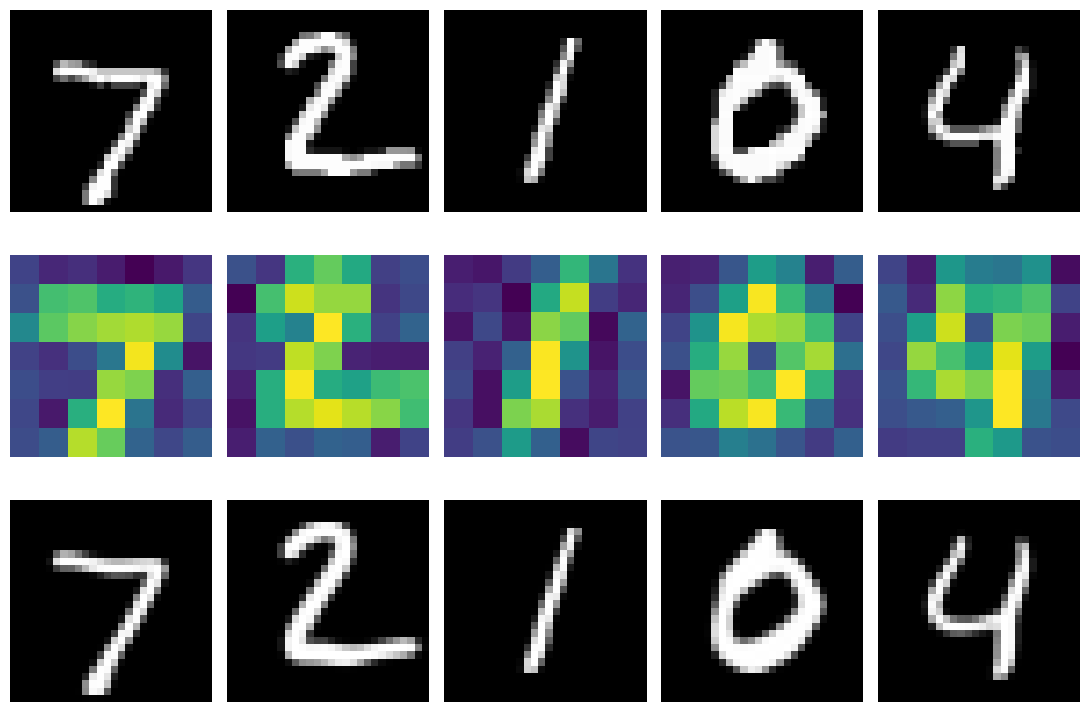

In [33]:
test_inference_spatial(spatial_49, test_ds, range(5))

In [35]:
torch.save(spatial_49.state_dict(), "spatial_ae_49.pth")

In [ ]:
from matplotlib import pyplot as plt
img = train_dl.dataset.data[0].numpy()
plt.imshow(img, cmap='gray')

In [8]:
from tqdm import tqdm

project = 'spatial_vae_conv_testing'
def train_model(model, train_loader, val_loader, name=None, epochs=20, lr=0.002):
    # Initialize wandb
    wandb.finish()
    wandb.init(project=project, name=name, reinit='finish_previous')
    wandb.config.update({
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": lr,
        "model": model.__class__.__name__,
        "optimizer": "Adam"
    })

    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    # or mse
    # criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-5)

    global_step = 0
    exp_beta = 0.97  # Use for getting prettier avg train loss
    train_loss_avg = None

    for epoch in range(epochs):
        # Training phase
        model.train()
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # Log every step
            train_loss_avg = loss.item() if train_loss_avg is None else train_loss_avg * exp_beta + loss.item() * (1 - exp_beta)

            with torch.no_grad():
                train_acc = (output.argmax(dim=1).eq(target)).float().mean().item()
                train_acc_avg = train_acc if train_acc_avg is None else train_acc_avg * exp_beta + train_acc * (1 - exp_beta)

            wandb.log({
                "step": global_step,
                "train_loss": train_loss_avg,
                "train_acc": train_acc_avg,
                "epoch": epoch + 1
            })

            global_step += 1
            pbar.set_postfix({'Train_Loss': f'{train_loss_avg:.4f}', 'Train_Acc': f'{train_acc_avg:.4f}'})

        # Evaluation phase (once per epoch)
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)

        val_loss /= len(val_loader)
        val_acc = 100. * correct / total

        wandb.log({
            "epoch": epoch + 1,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })

        print(f'Epoch {epoch+1}: Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        log_example_images(model, val_loader.dataset, epoch + 1, spatial=True)

    wandb.finish()
    return val_acc